# Get started with Flower
Welcome to the Flower federated learning tutorial!

In this notebook, we’ll build a federated learning system using the Flower framework, Flower Datasets and PyTorch. In part 1, we use PyTorch for the model training pipeline and data loading. In part 2, we federate the PyTorch project using Flower.

## Step 0: Preparation

### Loading dependencies

In [54]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.20.0 / PyTorch 2.8.0+cu128


### Loading Data

In [55]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

def load_datasets(partition_id: int):
    """Load datasets for a given partition ID."""
    fds = FederatedDataset(
        dataset="cifar10",
        partitioners = {
            "train": NUM_CLIENTS
        }
    )
    
    partition = fds.load_partition(partition_id)

    """Divide the partition into 80% train and 20% test sets."""

    partition_train_test = partition.train_test_split(
        train_size=0.8,
        seed=42
    )
    
    pytorch_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

    def apply_transform(batch):
        """Instead of passing transforms to CIFAR10(..., transform=transform)
        we will use this function to dataset.with_transform(apply_transforms)
        The transforms object is exactly the same"""
        batch["img"] = [pytorch_transform(img) for img in batch["img"]]
        return batch
    
    """Create train and test datasets with the applied transforms for each partition,
    and wrap them in DataLoader."""

    partition_train_test = partition_train_test.with_transform(apply_transform)
    trainloader = DataLoader(
        partition_train_test["train"], 
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    """Create a test DataLoader without shuffling
    to ensure that the test data is processed in the same order each time.
    This is important for evaluation consistency."""
    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
    )

    testset = fds.load_split("test")
    testset = testset.with_transform(apply_transform)
    testloader = DataLoader(
        testset,
        batch_size=BATCH_SIZE
    )

    return trainloader, valloader, testloader

Batch size: 32, Image shape: torch.Size([3, 32, 32]), Label shape: torch.Size([32])


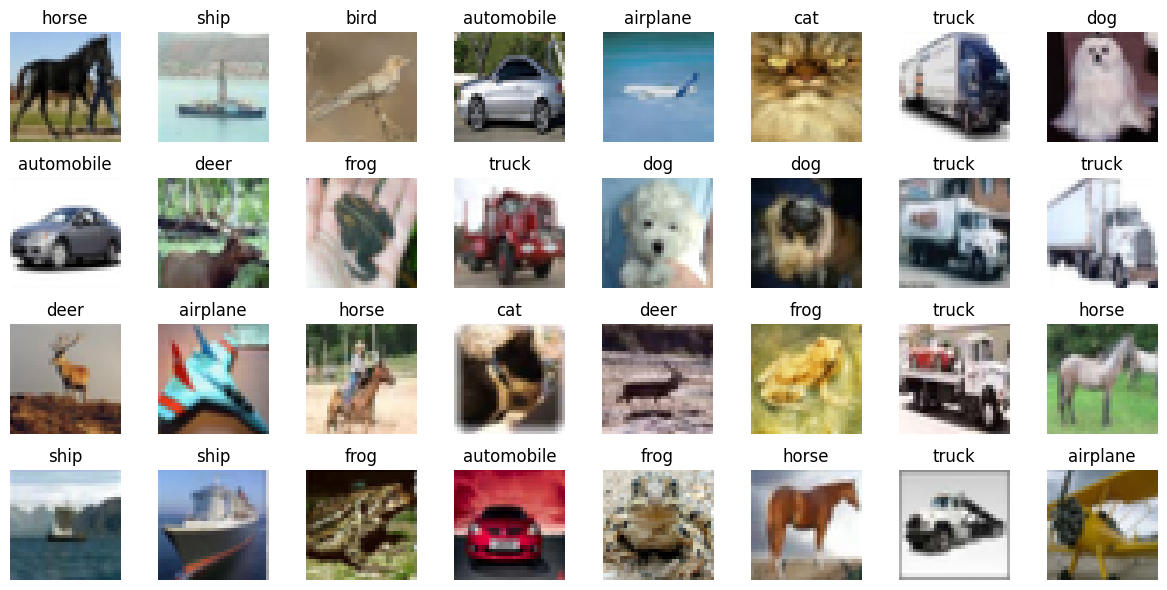

In [56]:
trainloader, _, _ = load_datasets(0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]
print(f"Batch size: {len(batch['img'])}, Image shape: {batch['img'][0].shape}, Label shape: {batch['label'].shape}")

# Reshape and convert images to numpy arrays for visualization
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()  # Change from (N, C, H, W) to (N, H, W, C)

# Denormalize images for better visualization
images = images / 2 + 0.5  # Reverse the normalization (0.5, 0.5, 0.5)

#Create a figure and grid of subplots
fig, axes = plt.subplots(4, 8, figsize=(12, 6))

# Loop through the first 32 images and their corresponding labels
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

## Step 1: Centralized Training with PyTorch

### Define the model

In [57]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [58]:
def train(net, trainloader, epochs: int, verbose=True):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


In [59]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### Train the model

In [60]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: train loss 0.06545782089233398, accuracy 0.21225
Epoch 1: validation loss 0.0597930291891098, accuracy 0.301
Epoch 1: train loss 0.05640785023570061, accuracy 0.33325
Epoch 2: validation loss 0.05308979570865631, accuracy 0.408
Epoch 1: train loss 0.05239085853099823, accuracy 0.3965
Epoch 3: validation loss 0.05123015701770783, accuracy 0.406
Epoch 1: train loss 0.04984745755791664, accuracy 0.4225
Epoch 4: validation loss 0.05027764594554901, accuracy 0.422
Epoch 1: train loss 0.04759928584098816, accuracy 0.4515
Epoch 5: validation loss 0.05007467710971832, accuracy 0.42
Final test set performance:
	loss 0.05042768179178238
	accuracy 0.4133


## Step 2: Federated Learning with Flower

### Update model parameters

In [61]:
def set_parameter(net, parameters: List[np.ndarray]):
    """Set the model parameters from a list of numpy arrays."""
    param_dict = zip(net.state_dict().keys(), parameters)

    state_dict = OrderedDict({k: torch.tensor(v, dtype=torch.float32).to(DEVICE) for k, v in param_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [v.cpu().numpy() for v in net.state_dict().values()]

### Define the Flower ClientApp

The first step toward creating a ClientApp is to implement a subclasses of flwr.client.Client or flwr.client.NumPyClient. We use NumPyClient in this tutorial because it is easier to implement and requires us to write less boilerplate. To implement NumPyClient, we create a subclass that implements the three methods get_parameters, fit, and evaluate:

get_parameters: Return the current local model parameters

fit: Receive model parameters from the server, train the model on the local data, and return the updated model parameters to the server

evaluate: Receive model parameters from the server, evaluate the model on the local data, and return the evaluation result to the server

In [62]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)
    
    def fit(self, parameters, config):
        set_parameter(self.net, parameters)
        train(self.net, self.trainloader, epochs=1, verbose=True)
        return get_parameters(self.net), len(self.trainloader.dataset), {}
    
    def evaluate(self, parameters, config):
        set_parameter(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [63]:
def client_fn(context: Context) -> Client:
    """Create a Flower client."""

    # Load model
    net = Net().to(DEVICE)
    """Load datasets for the given partition ID (CIFAR-10)
    Note: each client gets a different trainloader/valloader, so each client
    will train and evaluate on their own unique data partition
    Read the node_config to fetch data partition associated to this node"""

    """ Get the partition ID from the context
    # This is set by the server when it starts the simulation
    # and is used to identify which partition of the dataset this client should use
    # The partition ID is passed to the client via the context object
    # This allows the server to assign different partitions of the dataset to different clients"""
    
    partition_id = context.node_config["partition-id"]
    """Load the datasets for the given partition ID."""
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()

#Create the ClientApp
client = ClientApp(
    client_fn=client_fn
)

### Define the Flower ServerApp

In [64]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [65]:
def server_fn(context: Context) -> ServerAppComponents:
    """Create a Flower server."""
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """
    # Configure the server for 5 rounds of training
    # and use the FedAvg strategy for federated learning
    config = ServerConfig(
        num_rounds=5,  # Number of rounds of federated learning
    )

    return ServerAppComponents(
        strategy=strategy,
        config=config
    )

#Create the ServerApp
server = ServerApp(
    server_fn=server_fn
)

### Run the training

In [66]:
# Create a list of ClientConfig objects, one for each client
client_configs = [{"partition_id": i} for i in range(NUM_CLIENTS)]

# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0},
                      "client_configs": client_configs  # Pass the client configurations
                     }

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0},
                      "client_configs": client_configs  # Pass the client configurations
                     }
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [67]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [68]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create a new server instance with the updated FedAvg strategy
server = ServerApp(server_fn=server_fn)



# Run the simulation with the client_configs
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=62154) Epoch 1: train loss 0.06578674912452698, accuracy 0.209
(ClientAppActor pid=62154) Epoch 1: train loss 0.06554961204528809, accuracy 0.214
(ClientAppActor pid=62154) Epoch 1: train loss 0.06618564575910568, accuracy 0.193
(ClientAppActor pid=62154) Epoch 1: train loss 0.0648440346121788, accuracy 0.21325
(ClientAppActor pid=62154) Epoch 1: train loss 0.06515777856111526, accuracy 0.21875
(ClientAppActor pid=62154) Epoch 1: train loss 0.06600068509578705, accuracy 0.197
(ClientAppActor pid=62154) Epoch 1: train loss 0.06488720327615738, accuracy 0.214
(ClientAppActor pid=62154) Epoch 1: train loss 0.06506972759962082, accuracy 0.2085
(ClientAppActor pid=62154) Epoch 1: train loss 0.06555230170488358, accuracy 0.2075


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=62154) Epoch 1: train loss 0.06456445902585983, accuracy 0.232


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=62154) Epoch 1: train loss 0.05839632451534271, accuracy 0.294
(ClientAppActor pid=62154) Epoch 1: train loss 0.05857181176543236, accuracy 0.2915
(ClientAppActor pid=62154) Epoch 1: train loss 0.058412015438079834, accuracy 0.29425
(ClientAppActor pid=62154) Epoch 1: train loss 0.05759173631668091, accuracy 0.309
(ClientAppActor pid=62154) Epoch 1: train loss 0.05828062817454338, accuracy 0.29975
(ClientAppActor pid=62154) Epoch 1: train loss 0.058407049626111984, accuracy 0.29425
(ClientAppActor pid=62154) Epoch 1: train loss 0.05746062472462654, accuracy 0.3115
(ClientAppActor pid=62154) Epoch 1: train loss 0.05824386700987816, accuracy 0.29325
(ClientAppActor pid=62154) Epoch 1: train loss 0.058232203125953674, accuracy 0.297


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=62154) Epoch 1: train loss 0.05808929353952408, accuracy 0.302


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=62154) Epoch 1: train loss 0.05449386313557625, accuracy 0.35375
(ClientAppActor pid=62154) Epoch 1: train loss 0.05522044748067856, accuracy 0.348
(ClientAppActor pid=62154) Epoch 1: train loss 0.0545174703001976, accuracy 0.36175
(ClientAppActor pid=62154) Epoch 1: train loss 0.053406886756420135, accuracy 0.371
(ClientAppActor pid=62154) Epoch 1: train loss 0.0545336939394474, accuracy 0.3565
(ClientAppActor pid=62154) Epoch 1: train loss 0.05473218858242035, accuracy 0.3365
(ClientAppActor pid=62154) Epoch 1: train loss 0.05433402583003044, accuracy 0.35625
(ClientAppActor pid=62154) Epoch 1: train loss 0.05421019718050957, accuracy 0.3555
(ClientAppActor pid=62154) Epoch 1: train loss 0.054154038429260254, accuracy 0.358


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=62154) Epoch 1: train loss 0.05386640504002571, accuracy 0.36175


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=62154) Epoch 1: train loss 0.052196770906448364, accuracy 0.3905
(ClientAppActor pid=62154) Epoch 1: train loss 0.05283227190375328, accuracy 0.37175
(ClientAppActor pid=62154) Epoch 1: train loss 0.052669573575258255, accuracy 0.3845
(ClientAppActor pid=62154) Epoch 1: train loss 0.050771623849868774, accuracy 0.40475
(ClientAppActor pid=62154) Epoch 1: train loss 0.05239826440811157, accuracy 0.38675
(ClientAppActor pid=62154) Epoch 1: train loss 0.05243794247508049, accuracy 0.3695
(ClientAppActor pid=62154) Epoch 1: train loss 0.05152406543493271, accuracy 0.39775
(ClientAppActor pid=62154) Epoch 1: train loss 0.05226878449320793, accuracy 0.381
(ClientAppActor pid=62154) Epoch 1: train loss 0.05258216708898544, accuracy 0.3855


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=62154) Epoch 1: train loss 0.05140101909637451, accuracy 0.40225


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=62154) Epoch 1: train loss 0.05035160854458809, accuracy 0.406
(ClientAppActor pid=62154) Epoch 1: train loss 0.051350004971027374, accuracy 0.403
(ClientAppActor pid=62154) Epoch 1: train loss 0.05051705613732338, accuracy 0.41125
(ClientAppActor pid=62154) Epoch 1: train loss 0.049536511301994324, accuracy 0.42375
(ClientAppActor pid=62154) Epoch 1: train loss 0.050365447998046875, accuracy 0.404
(ClientAppActor pid=62154) Epoch 1: train loss 0.051028646528720856, accuracy 0.3975
(ClientAppActor pid=62154) Epoch 1: train loss 0.05009059980511665, accuracy 0.408
(ClientAppActor pid=62154) Epoch 1: train loss 0.050639815628528595, accuracy 0.39975
(ClientAppActor pid=62154) Epoch 1: train loss 0.05035875737667084, accuracy 0.4115


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=62154) Epoch 1: train loss 0.050301872193813324, accuracy 0.41025


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 334.84s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06357202031612395
INFO :      		round 2: 0.055125981497764584
INFO :      		round 3: 0.05285978472232818
INFO :      		round 4: 0.050728287029266364
INFO :      		round 5: 0.049071466612815855
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.2708),
INFO :      	              (2, 0.3688),
INFO :      	              (3, 0.39580000000000004),
INFO :      	              (4, 0.42460000000000003),
INFO :      	              (5, 0.4486)]}
INFO :      
